<a href="https://colab.research.google.com/github/JacquesBLR/Causal_Inference/blob/main/Mesurer_l'effet_d'une_publicit%C3%A9_Ciblage_en_ligne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Publicité en ligne :** Nous disposons des données de navigation et d’achat d’un échantillon de
clients, dont certains ont été exposés à la campagne de retargeting ( expose=1 ) et d’autres non
( expose=0 ). Les variables clés sont les suivantes :
- **Score d’intérêt préalable** (par ex. nombre de pages vues, articles ajoutés au panier, score
d’appétence) – car la campagne cible prioritairement les clients à fort intérêt.
- Variable binaire **expose** : a reçu au moins une impression de l’annonce de retargeting.
- Variable binaire **conversion** : a effectué un achat dans la période suivant l’exposition potentielle.


On génère un score d’intérêt aléatoire et on décide que $P(\text{exposition})$ augmente avec ce score (pour refléter le
ciblage), et $P(\text{conversion})$ augmente aussi avec l’intérêt et un peu avec la pub (effet causal).  
Important : la distribution du score d’intérêt diffère fortement entre exposés et non-exposés,
créant un biais. L’objectif sera de corriger ce biais par matching.

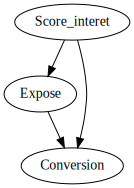

In [ ]:
from graphviz import Digraph

dot = Digraph()

dot.node('T', 'Expose')
dot.node('Y', 'Conversion')
dot.node('Z', 'Score_interet')

dot.edges([('Z', 'T'), ('Z', 'Y'), ('T', 'Y')])

dot  # Affiche directement le DAG dans la cellule



# 1. Exploration des données et constat du biais de sélection :

In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
np.random.seed(0)
N = 5000
# Score d'intérêt simulé (0 à 10)
score_interet = np.random.rand(N) * 10
# Probabilité d'exposition augmente avec l'intérêt (sigmoïde)
p_expo = 1 / (1 + np.exp(-(-2 + 0.5 * score_interet))) # logit(-2 + 0.5*score)
expose = np.random.binomial(1, p_expo, size=N)
# Probabilité de conversion dépend de l'intérêt et un peu de l'exposition
p_conv = 1 / (1 + np.exp(-(-4 + 0.8 * score_interet + 1.0 * expose)))
conversion = np.random.binomial(1, p_conv, size=N)
df_ads = pd.DataFrame({'score_interet': score_interet, 'expose': expose,
'conversion': conversion})

# Taux de conversion bruts
taux_conv = df_ads.groupby('expose')['conversion'].mean()
print("Taux conversion non exposés: {:.1%}".format(taux_conv[0]))
print("Taux conversion exposés: {:.1%}".format(taux_conv[1]))
print("Ratio exposés dans population: {:.1%}".format(df_ads['expose'].mean()))
print("Score d'intérêt moyen (non exposés) = {:.2f}, (exposés) = {:.2f}".format(
df_ads[df_ads.expose==0]['score_interet'].mean(),
df_ads[df_ads.expose==1]['score_interet'].mean()))

Taux conversion non exposés: 26.1%
Taux conversion exposés: 78.4%
Ratio exposés dans population: 58.1%
Score d'intérêt moyen (non exposés) = 3.09, (exposés) = 6.32


**Interprétation initiale** : Naïvement, on pourrait dire “ceux qui ont vu la pub ont 81.7% de conversion vs
25.8% sinon, la pub semble augmenter les conversions de +56 points”.  
Mais on voit que le score
d’intérêt moyen des exposés (≈6.50) est bien supérieur à celui des non-exposés (≈3.08).  
Clairement,
les exposés étaient un public bien plus chaud. Une bonne partie de l’écart de conversion est dû à ce
biais d’appariement : on ne compare pas des populations comparables.

# 2. Calcul du score de propension (propensity score) :

On estime la probabilité d’exposition en fonction
du score d’intérêt via une régression logistique. Ce score de propension $e(x)=P(\text{expose}=1|
\text{score_interet}=x)$ nous permettra d’apparier des individus exposés et non-exposés similaires

In [ ]:
# Modèle de propension P(expose=1 | score_interet)
logit = LogisticRegression(solver='lbfgs')
logit.fit(df_ads[['score_interet']], df_ads['expose'])
df_ads['propension'] = logit.predict_proba(df_ads[['score_interet']])[:,1]
print("Coefficient logit(score_interet)->expose: {:.3f}".format(logit.coef_[0][0]))

Coefficient logit(score_interet)->expose: 0.497


In [ ]:
def plot_results(ps_values, swang1, name=""):
    auc = round(roc_auc_score(swang1, ps_values), 4)
    sns.kdeplot(
        x=ps_values, hue=swang1, fill=True, common_norm=False, alpha=0.4).set_title(f"AUC {name}:{auc}")
    plt.show()

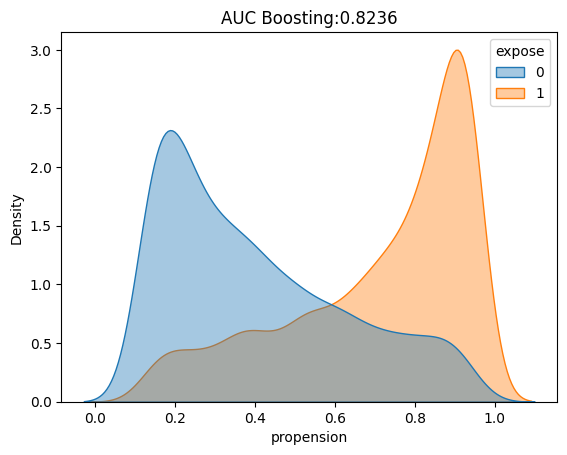

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
plot_results(df_ads['propension'], df_ads['expose'] , "Boosting")

Le coefficient positif (~0.5 ici) confirme que plus le score d’intérêt est élevé, plus on a de chances d’être
exposé, ce qui correspond à la politique de ciblage. La distribution des scores de propension des deux
groupes montre l’étendue du chevauchement (overlap). Si certains exposés ont des scores beaucoup
plus hauts que tous les non-exposés, il sera difficile de trouver des témoins comparables – c’est le
cas dans notre simulation où le chevauchement est partiel.

# 3. Matching des individus (appariement) :
On va appairer chaque individu exposé avec un ou plusieurs individus non-exposés de score de propension proche. L’idéal est d’utiliser un algorithme de
matching (p. ex. plus proche voisin). En Python pur, on peut réaliser un appariement simple manuel.

On
peut estimer l’effet moyen du traitement sur les traités via une pondération par score de propension.
On pondère chaque individu non-exposé par $\frac{ps(x)}{1-ps(x)}$ pour qu’ils ressemblent à la population
exposée . Ensuite on compare la conversion moyenne pondérée.

In [ ]:
# Estimation de l'effet par pondération IPTW (ATT = effet moyen sur les exposés)
traites = df_ads[df_ads.expose==1]
temoins = df_ads[df_ads.expose==0]
# Poids pour les témoins: p/(1-p), pas de poids (1) pour traités
temoins['poids'] = temoins['propension'] / (1 - temoins['propension'])
# Calcul du taux de conversion pondéré des témoins
taux_conv_pondere_temoins = np.average(temoins['conversion'],
weights=temoins['poids'])
taux_conv_traites = traites['conversion'].mean()
effet_att = taux_conv_traites - taux_conv_pondere_temoins


Remarque: Dans le code ci-dessus, on calcule l’Effet Moyen sur les Traités (ATT), c’est-à-dire l’incrément
de conversion dû à la pub parmi la population effectivement ciblée. On aurait pu estimer l’effet moyen
global (ATE) via une pondération symétrique, mais en marketing l’ATT est souvent la mesure pertinente
(impact de la campagne sur sa cible).

In [ ]:
print("Taux conv. traités = {:.1%}, Taux conv. témoins pondérés = {:.1%}".format(taux_conv_traites, taux_conv_pondere_temoins))
print("Effet causal estimé (ATT) = +{:.1f} points".format(effet_att*100))

Taux conv. traités = 78.4%, Taux conv. témoins pondérés = 66.9%
Effet causal estimé (ATT) = +11.5 points


Donc, après ajustement, on estime que la publicité a augmenté le taux de conversion d’environ +12-13
points chez les personnes ciblées (par exemple de 69% à 81.7%). C’est bien moindre que les +56 points
naïfs ! La correction par matching/pondération a enlevé le biais de sélection lié au ciblage. En pratique,
un lift de +12 points reste très appréciable, mais l’entreprise aurait pu surévaluer dramatiquement la
campagne si elle avait cru au 81% vs 26% brut.

Notons que cet ATT estimé reste une approximation valide sous l’hypothèse d’ignorabilité
conditionnelle : on suppose que toutes les variables confondantes (ici l’intérêt client) ont été prises en
compte dans le score de propension. Si des facteurs non-observés influencent à la fois la probabilité
d’exposition et la conversion (par ex. besoin du produit, revenu, etc. non inclus), le résultat peut encore
être biaisé. L’analyse de sensibilité et la collecte de données additionnelles sont alors recommandées.

# 4. Interprétation et limites :

L’analyse ajustée suggère que “la campagne de retargeting en
ligne a causé une augmentation d’environ 12 points du taux de conversion auprès de la cible visée”. C’est
l’effet incrémental qu’on peut attribuer à la pub, toutes choses égales par ailleurs.
Hypothèses pour valider cette conclusion : (a) on a mesuré et utilisé les principaux déterminants de
l’exposition et de la conversion (ici le score d’intérêt) – en d’autres termes, pas de biais confondant non
observé ; (b) il existe un bon chevauchement entre exposés et non-exposés en termes de score de
propension – si certains exposés sont hors distribution (score trop élevé, sans équivalent chez les nonexposés),
l’estimation pour eux repose sur de l’extrapolation incertaine.
Dans notre exemple, le chevauchement était imparfait (peu de non-exposés avec un score >8). Dans la
réalité, cela peut se produire : si le ciblage est trop strict (on n’expose que les meilleurs clients), on ne
peut plus déduire ce qui se serait passé sans pub pour ces clients-là faute de comparatifs. On
mentionnera qu’alors d’autres méthodes peuvent aider, par ex. trouver un instrument affectant
l’exposition (budget aléatoire, rotation aléatoire des pubs) ou recourir à un modèle causale bayésien
pour extrapoler avec des hypothèses. Ces points peuvent être discutés en fin de case

Nous avons supposé que le ciblage de la pub en ligne dépendait
uniquement (ou principalement) du score d’intérêt connu.  
En pratique, s’il y a des facteurs non observés
(ex : la pub n’est affichée qu’à certaines heures, et ces heures correspondent aussi à des moments de
forte propension à acheter indépendamment de la pub), l’estimation peut encore être biaisée.  
C’est le
problème général des études observationnelles : **il faut juger de la plausibilité que toutes les différences
entre exposés et non-exposés soient expliquées par les variables contrôlées**.  
Ici, on pourrait
améliorer en incluant davantage de variables (âge, ancienneté client, etc.) dans le calcul du score de
propension, pour affiner le matching.  
Une autre limite est la portée de l’effet mesuré : on obtient un effet moyen sur la population ciblée sur
une période donnée. **Peut-être que la pub a surtout fait acheter plus tôt des clients qui auraient de
toute façon acheté plus tard** (simple accélération).  
Sans groupe de contrôle à plus long terme, on ne sait
pas si l’effet est persistant ou s’il s’agit en partie d’un déplacement dans le temps (effet “cannibale” sur
les ventes futures).  
Idéalement, il faudrait un suivi plus long et/ou d’autres métriques (valeur client à
long terme).

# 5. Annexe

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors



Calcul propensity score avec ML et cross-fitting (Script 1 : plus clair)

In [ ]:
def train_model(X, y):
    clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
    clf.fit(X, y)
    return clf

In [ ]:
from sklearn.model_selection import train_test_split

X = df_ads[['score_interet']]
T = df_ads['expose']

# we create two datasets D1 and D2 randomly. We stratify by the outcome swang1 to guarantee a balanced dataset with respect the outcome
D1_X, D2_X, D1_T, D2_T = train_test_split(X, T, test_size=0.5, stratify=T)

ps_model_boost_1 = train_model(D1_X, D1_T)
ps_model_boost_2 = train_model(D2_X, D2_T)

# We predict on the dataset D1 using the model trained on D2 and vice versa
ps_1 = ps_model_boost_2.predict_proba(D1_X)[:, 1]
ps_2 = ps_model_boost_1.predict_proba(D2_X)[:, 1]

expose = pd.concat([D1_T, D2_T])
ps_values = np.concatenate([ps_1, ps_2])
print(roc_auc_score(expose, ps_values))

0.8163034972834406


Calcul propensity score avec ML et cross-fitting (Script 2 : plus optimisé)

In [ ]:
# Variables
X = df_ads[['score_interet']]
T = df_ads['expose']

# Cross-fitting (2 folds)
propensity_scores = np.zeros(len(df_ads))
kf = KFold(n_splits=2, shuffle=True, random_state=0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    T_train = T.iloc[train_index]
    clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
    clf.fit(X_train, T_train)
    propensity_scores[test_index] = clf.predict_proba(X_test)[:, 1]

df_ads['propensity_score'] = propensity_scores

Matching avec nearest neighboor

In [ ]:
# Appariement 1-to-1 sur le score de propension avec replacement
treated = df_ads[df_ads.expose == 1].copy()
control = df_ads[df_ads.expose == 0].copy()

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])


In [ ]:
matched_control = control.iloc[indices.flatten()].copy()
matched_control.index = treated.index  # Alignement des index pour concaténation

matched_df = pd.concat([
    treated[['conversion']],
    matched_control[['conversion']]
], axis=1)
matched_df.columns = ['Y_treated', 'Y_control']


In [ ]:
matched_control

In [ ]:
# Calcul ATT : moyenne des différences
ATT = (matched_df['Y_treated'] - matched_df['Y_control']).mean()


In [ ]:
ATT

np.float64(0.12659098727210183)